# Congressional Speech Analysis

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.max_columns = 1200  
pd.options.display.max_rows = 1200 

import unicodedata
import itertools
import datetime
import datefinder
import operator
import string
import re

import nltk
from nltk.tokenize import sent_tokenize

def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

### Get speeches

In [3]:
from IPython.display import clear_output

FILES_PATH = '/Users/yc00027/Documents/GitHub/congress_speech_analysis/Data'

congresses = sorted(listdir_nohidden(FILES_PATH))

congressional_hearings = []

for congress in congresses:
    clear_output()
    print(f'Now loading congress {congress}')
    offices = listdir_nohidden(congress)
    for office in offices:
        clear_output()
        print(f'Now loading office {office}')
        congress = os.path.split(os.path.dirname(office))[1]
        departments = listdir_nohidden(office)
        for department in departments:
            clear_output()
            office = os.path.split(os.path.dirname(department))[1]
            try:
                session_files = listdir_nohidden(department)
            except:
                print(f'No txt files for session {session}')
                continue

            txt_files = [f for f in session_files if f.endswith('.txt')]
            for file in txt_files:
                with open(file, errors='replace') as f:
                    document = f.read().lower() 
                    department = os.path.split(os.path.dirname(file))[1]
                    name = os.path.basename(file)
                    congressional_hearings.append([document, congress, office, department, name])
            
clear_output()
print('Done')

congressional_hearings_df = pd.DataFrame(congressional_hearings).reset_index().rename(columns={'index': 'document_id'})
congressional_hearings_df.columns = ['document_id', 'document', 'congress','office','department','name']
congressional_hearings_df = congressional_hearings_df.sort_values(by=['congress', 'office','department','name'])

print(f'Congressional Hearings DF shape: {congressional_hearings_df.shape}')
congressional_hearings_df.head()

Done
Congressional Hearings DF shape: (2535, 6)


,document_id,document,congress,office,department,name
1837,1837,\n - eastern mediterranean energy: challenges ...,114th,House,Ad Hoc Committee on Energy,1.txt
1659,1659,\n - [errata] manipulation and fraud in the re...,114th,House,Commission on Security and Cooperation in Europe,1.txt
1658,1658,\n - the rule of law and civil society in azer...,114th,House,Commission on Security and Cooperation in Europe,2.txt
1657,1657,\n - human rights violations in russian-occupi...,114th,House,Commission on Security and Cooperation in Europe,3.txt
1656,1656,\n - nato's warsaw summit and the future of eu...,114th,House,Commission on Security and Cooperation in Europe,4.txt


In [137]:
path = '/Users/yc00027/Documents/GitHub/congress_speech_analysis/speeches_df.csv'
speeches_df = pd.read_csv(path).reset_index().rename(columns={'index': 'unique_sentence_id'})
speeches_df.drop(columns=['speech'], inplace=True)

print(f'Speeches DF shape: {speeches_df.shape}')
speeches_df.head()

Speeches DF shape: (1471194, 11)


,unique_sentence_id,document_id,speech_id,document_title,hearing_date,chairman,speech_len,sentence,sentence_id,clean_speaker_name,sentence_len
0,0,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,when i spoke to the american legion at \nthe b...,56,john isakson,46
1,1,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,first and foremost was veterans' \nhomelessnes...,57,john isakson,25
2,2,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,"while it is improving in terms of lessening, i...",58,john isakson,20
3,3,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,we have two \ndistinguished panels who will ta...,59,john isakson,19
4,4,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,"from 2010 to 2014, the number of homeless vete...",60,john isakson,14


In [5]:
bills93_114_df = pd.read_csv('bills93-114.csv', error_bad_lines=False, encoding='ISO-8859-1', sep = ';')
bills_114 = bills93_114_df[bills93_114_df['Cong'] == 114]
bills_114 = bills_114[bills_114['BillType'].isin(['hr', 's'])]

print(f'There were {bills_114.shape[0]} bills in Congress 114th.')

speaker_names = sorted(bills_114['NameFull'].str.lower().unique())
print(f'There were {len(speaker_names)} speakers in Congress 114th.')
print('')

print('Number of bills according to bill type:')
print(bills_114['BillType'].value_counts())
print('')

print('Bill types: "hr" (House Bill); "s" (Senate Bill); "hres" (House Resolution); "sres" (Senate Resolution); \
                   "hcon" (House Concurrent Resolution); "scon" (Senate Concurrent Resolution); \
                   "hjres" (House Joint Resolution); "sjres" (Senate Joint Resolution).')

bills_114.head()

There were 10055 bills in Congress 114th.
There were 542 speakers in Congress 114th.

Number of bills according to bill type:
hr    6508
s     3547
Name: BillType, dtype: int64

Bill types: "hr" (House Bill); "s" (Senate Bill); "hres" (House Resolution); "sres" (Senate Resolution);                    "hcon" (House Concurrent Resolution); "scon" (Senate Concurrent Resolution);                    "hjres" (House Joint Resolution); "sjres" (Senate Joint Resolution).


,BillID,BillNum,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,MultNo,PLaw,Private,Title,Veto,Class,ComC,ComR,CumHServ,CumSServ,Delegate,District,DW1,FrstConH,FrstConS,Gender,MemberID,MRef,NameFirst,NameFull,NameLast,Party,PooleID,Postal,State,URL,ChRef,RankRef,PassH,PassS,PLawDate,PLawNum,ImpBill,SubChRef,SubRankRef,Majority,ReportH,ReportS,Major,Minor
282772,114-HR-2,2,hr,0,114,13.0,2015-03-24,1.0,6.0,1,0,To amend title XVIII of the Social Security Ac...,0,NaN,1.0,0.0,5110.0,0.0,0,26.0,"0,565",0.0,0.0,0,20355-114-200,1,Michael,Michael Burgess,Burgess,200.0,20355.0,TX,49,https://www.congress.gov/bill/114th-congress/h...,0,0,1,1,NaN,320,1.0,0.0,0.0,1,0,0,3.0,323.0
282773,114-HR-3,3,hr,0,114,30.0,2015-01-06,1.0,3.0,0,0,To approve the Keystone XL Pipeline.,0,NaN,0.0,0.0,1461.0,0.0,0,0.0,"0,375",0.0,0.0,0,21350-114-200,1,Kevin,Kevin Cramer,Cramer,200.0,21350.0,ND,36,https://www.congress.gov/bill/114th-congress/h...,0,0,1,0,NaN,NaN,1.0,0.0,0.0,1,0,0,8.0,803.0
282774,114-HR-5,5,hr,0,114,11.0,2015-02-03,1.0,2.0,0,0,To support State and local accountability for ...,0,NaN,1.0,0.0,5110.0,0.0,0,2.0,"0,49",0.0,0.0,0,20333-114-200,1,John,John Kline,Kline,200.0,20333.0,MN,33,https://www.congress.gov/bill/114th-congress/h...,1,0,1,0,NaN,NaN,1.0,0.0,0.0,1,1,0,6.0,602.0
282775,114-HR-6,6,hr,0,114,230.0,2015-05-19,1.0,3.0,0,0,"To accelerate the discovery, development, and ...",0,NaN,1.0,0.0,10955.0,0.0,0,6.0,"0,337",0.0,0.0,0,15446-114-200,1,Fred,Fred Upton,Upton,200.0,15446.0,MI,23,https://www.congress.gov/bill/114th-congress/h...,1,0,1,0,NaN,NaN,1.0,0.0,0.0,1,1,0,3.0,398.0
282776,114-HR-7,7,hr,0,114,29.0,2015-01-21,1.0,4.0,0,0,To prohibit taxpayer funded abortions.,0,NaN,1.0,0.0,13147.0,0.0,0,4.0,"0,156",0.0,0.0,0,14863-114-200,0,Christopher,Christopher Smith,Smith,200.0,14863.0,NJ,12,https://www.congress.gov/bill/114th-congress/h...,0,0,1,0,NaN,NaN,1.0,0.0,0.0,1,0,0,2.0,208.0


### Get bills

In [6]:
characters = ["-", "...", "''", "``", "@", "#",  
              '--', '=', '_', '..', '|', "/",
              '~', '—', '•', '“', '–', '>', '*']

def clean_text(text):
    '''Remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = text.replace(' \n', ' ')
    for character in characters:
        text = text.replace(character, " ")
    text = ' '.join(text.split())
    return text

In [138]:
speeches_df.head()

,unique_sentence_id,document_id,speech_id,document_title,hearing_date,chairman,speech_len,sentence,sentence_id,clean_speaker_name,sentence_len
0,0,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,when i spoke to the american legion at \nthe b...,56,john isakson,46
1,1,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,first and foremost was veterans' \nhomelessnes...,57,john isakson,25
2,2,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,"while it is improving in terms of lessening, i...",58,john isakson,20
3,3,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,we have two \ndistinguished panels who will ta...,59,john isakson,19
4,4,0,55.0,ending veteran homelessness,"july 29, 2015",johnny isakson,354,"from 2010 to 2014, the number of homeless vete...",60,john isakson,14


In [161]:
speeches_df.shape

(1471194, 11)

In [160]:
speeches_df.unique_sentence_id.nunique()

1471194

In [9]:
print(len([sentence for sentence in speeches_df['sentence'].unique() if 'h.r.' in sentence]))
print(len([sentence for sentence in speeches_df['sentence'].unique() if ' s.' in sentence]))

1670
876


In [121]:
bills_1 = []
sentences = [sentence for sentence in speeches_df['sentence']]

for i, sentence in enumerate(sentences):
    if 'h.r.' in sentence:
        try:
            if sentence.split('h.r. ')[1].split(' ')[0].isdigit():
                bills_1.append({'sentence_id': i,
                              'bill_id': sentence.split('h.r. ')[1].split(' ')[0],
                              'bill_type': 'hr',
                              'sentence': sentence
                              })
        except IndexError:
            i_plus = 1
            sentence += sentences[i+i_plus]
            bills_1.append({'sentence_id': i,
                          'bill_id': sentences[i+i_plus].split(' ')[0],
                          'bill_type': sentences[i].split(' ')[-1],
                          'sentence': sentence
                          })
            
    elif ' s. ' in sentence:
        try:
            if sentence.split(' s. ')[1].split(' ')[0].isdigit():
                bills_1.append({'sentence_id': i,
                          'bill_id': sentence.split(' s. ')[1].split(' ')[0],
                          'bill_type': 's',
                          'sentence': sentence
                             })
        except IndexError:
            i_plus = 1
            sentence += sentences[i+i_plus]
            bills_1.append({'sentence_id': i,
                          'bill_id': sentences[i+i_plus].split(' ')[0],
                          'bill_type': sentences[i].split(' ')[-1],
                          'sentence': sentence
                          })
    else:
        continue

bills_1_df = pd.DataFrame(bills_1)
bills_1_df['sentence'] = [clean_text(sentence) for sentence in bills_1_df['sentence']]

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

repl_dict = {'),' : '', '.': '', ',': '', ';': '', ')': '', '\n': '', '(': '', '``':'', 'follows:]':'', 
            'bill--hr': 'hr', 'vahr': 'hr', 'introduced--hr': 'hr', 'education--hr': 'hr', '160/hr': 'hr', 
             'organizations--hr': 'hr', '829/hr': 'hr', 'hr?' : 'hr',  '2612/hr' : 'hr',  'bills--hr' : 'hr', 
             'me--hr' : 'hr', 'to--hr' : 'hr',  "hr''" : 'hr'}

bills_1_df['bill_id'] = bills_1_df['bill_id'].apply(lambda x: replace_all(x, repl_dict))
bills_1_df['bill_type'] = bills_1_df['bill_type'].apply(lambda x: replace_all(x, repl_dict))

bills_1_df = bills_1_df[bills_1_df['bill_id'].apply(lambda x: x.isdigit())]
bills_1_df = bills_1_df[bills_1_df['bill_type'].isin(['hr', 's'])] 

print(f'Bills DF shape: {bills_1_df.shape}')
bills_1_df.head()

Bills DF shape: (1754, 4)


,bill_id,bill_type,sentence,sentence_id
0,901,s,your testimony indicates the department has pr...,2261
1,901,s,please provide specific changes and recommenda...,2401
2,901,s,i understand that you have stories from famili...,2462
3,2496,hr,"on may 22, 2015, public law 114 19 (h.r.2496),...",7653
5,290,s,you mentioned specifically the blumenthal bill...,8697


In [79]:
bill_types = [' hr ', ' hr', ' h.r. ', ' h.r.', ' hr. ', ' hr.',
              ' hconres ', ' hconres',  ' hconres. ', ' hconres.', 
              ' hjres ', ' hjres', ' hjres. ', ' hjres.',
              ' hres ', ' hres', ' hres. ', ' hres.',
              ' s. ', ' s.', ' s_ ', ' s_', ' sb ',
              ' sconres ', ' sconres', ' sconres. ', ' sconres.',
              ' sjres ', ' sjres', ' sjres. ', ' sjres.',
              ' sres ', ' sres', ' sres. ', ' sres.']

bills = []

for index, sentence in zip(speeches_df.index, speeches_df['sentence']):
    sentence = sentence.replace(' s. ', ' sb ').replace(' h.r.', ' hr ').replace(' h.r. ', ' hr ').replace(' s.', ' sb ')
    if any(x in sentence for x in bill_types):
        try:
            regex = re.compile(r'(?: h.r. | hr | hr. |hr| hconres | hconres. | hjres | hjres. | hres | hres. | \
                                     s. | sb | sconres | sconres. | sjres | sjres. | sres | sres. )+(\d+)+')
            bills.append({'sentence_id': index,
                            'bill_id': regex.findall(sentence),
                            'bill_type': [b for b in bill_types if b in sentence],
                            'sentence': sentence
                            })
        except Exception as e:
            print(sentence)
            raise(e)  

bills_df = pd.DataFrame(bills)

bills_df = bills_df[bills_df.astype(str)['bill_id'] != "[]"]
bills_df['bill_id'] = bills_df['bill_id'].str[0]
bills_df['bill_type'] = bills_df['bill_type'].str[0]
bills_df['bill_type'] = bills_df['bill_type'].replace(" sb ", "s").replace(" s.", "s").replace(" hr ", "hr").replace(" hr", "hr")
bills_df['sentence'] = [clean_text(sentence) for sentence in bills_df['sentence']]

print(f'Bills DF shape: {bills_df.shape}')
print(f'There are {bills_df.bill_id.nunique()} unique bills in the dataframe.')
print('')
print('Number of S. bills and number of H.R. bills:')
print('')
print(bills_df.bill_type.value_counts())
print('')
bills_df.head()

Bills DF shape: (558, 4)
There are 248 unique bills in the dataframe.

Number of S. bills and number of H.R. bills:

s     539
hr     19
Name: bill_type, dtype: int64



,bill_id,bill_type,sentence,sentence_id
0,425,s,senator tester and i have introduced legislati...,206
2,425,s,this fix would be accomplished by a bill curre...,885
3,2081,s,"to this end, i have introduced sb 2081, which ...",1784
4,901,s,"now, in your objection to sb 901, the toxic ex...",1940
5,901,s,"i think that is sb 901, if i am not mistaken, ...",1961


In [153]:
_bills_df = pd.concat([bills_df, bills_1_df]).groupby('sentence_id').first().reset_index()
print(_bills_df.shape)
_bills_df.head()

(2140, 4)


,sentence_id,bill_id,bill_type,sentence
0,206,425,s,senator tester and i have introduced legislati...
1,885,425,s,this fix would be accomplished by a bill curre...
2,1784,2081,s,"to this end, i have introduced sb 2081, which ..."
3,1940,901,s,"now, in your objection to sb 901, the toxic ex..."
4,1961,901,s,"i think that is sb 901, if i am not mistaken, ..."


In [154]:
_bills_df.bill_type.value_counts()

hr    1601
s      539
Name: bill_type, dtype: int64

In [163]:
bills_final_df = pd.merge(_bills_df, speeches_df.drop(columns=['sentence', 'sentence_id']), left_on='sentence_id', right_on = 'unique_sentence_id', how='left')
print(bills_final_df.shape)
bills_final_df.head()

(2140, 13)


,sentence_id,bill_id,bill_type,sentence,unique_sentence_id,document_id,speech_id,document_title,hearing_date,chairman,speech_len,clean_speaker_name,sentence_len
0,206,425,s,senator tester and i have introduced legislati...,206,0,600.0,ending veteran homelessness,"july 29, 2015",johnny isakson,207,john boozman,33
1,885,425,s,this fix would be accomplished by a bill curre...,885,0,2439.0,ending veteran homelessness,"july 29, 2015",johnny isakson,3705,john isakson,23
2,1784,2081,s,"to this end, i have introduced sb 2081, which ...",1784,2,48.0,examining the impact of exposure to toxic chem...,"september 29, 2015",johnny isakson,297,richard blumenthal,19
3,1940,901,s,"now, in your objection to sb 901, the toxic ex...",1940,2,356.0,examining the impact of exposure to toxic chem...,"september 29, 2015",johnny isakson,26,john isakson,23
4,1961,901,s,"i think that is sb 901, if i am not mistaken, ...",1961,2,399.0,examining the impact of exposure to toxic chem...,"september 29, 2015",johnny isakson,388,mike rounds,16


In [169]:
congress_114_bills_df = pd.merge(bills_final_df, congressional_hearings_df.reset_index().drop(columns=['document']), on='document_id', how='left')

congress_114_bills_df.drop(columns=['index', 'sentence_id'], inplace=True)

print(f'Full 114th Congress Bills DF shape: {congress_114_bills_df.shape}')
congress_114_bills_df.head()

Full 114th Congress Bills DF shape: (2140, 16)


,bill_id,bill_type,sentence,unique_sentence_id,document_id,speech_id,document_title,hearing_date,chairman,speech_len,clean_speaker_name,sentence_len,congress,office,department,name
0,425,s,senator tester and i have introduced legislati...,206,0,600.0,ending veteran homelessness,"july 29, 2015",johnny isakson,207,john boozman,33,114th,Senate,Committee on Veterans Affairs,15.txt
1,425,s,this fix would be accomplished by a bill curre...,885,0,2439.0,ending veteran homelessness,"july 29, 2015",johnny isakson,3705,john isakson,23,114th,Senate,Committee on Veterans Affairs,15.txt
2,2081,s,"to this end, i have introduced sb 2081, which ...",1784,2,48.0,examining the impact of exposure to toxic chem...,"september 29, 2015",johnny isakson,297,richard blumenthal,19,114th,Senate,Committee on Veterans Affairs,16.txt
3,901,s,"now, in your objection to sb 901, the toxic ex...",1940,2,356.0,examining the impact of exposure to toxic chem...,"september 29, 2015",johnny isakson,26,john isakson,23,114th,Senate,Committee on Veterans Affairs,16.txt
4,901,s,"i think that is sb 901, if i am not mistaken, ...",1961,2,399.0,examining the impact of exposure to toxic chem...,"september 29, 2015",johnny isakson,388,mike rounds,16,114th,Senate,Committee on Veterans Affairs,16.txt


### Sentiment Analysis

In [170]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))
    
# getting only the negative score
def negative_score(text):
    negative_value = analyser.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyser.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyser.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyser.polarity_scores(text)['compound']
    return compound_value

In [171]:
congress_114_bills_df['sentiment_neg'] = congress_114_bills_df['sentence'].apply(negative_score)
congress_114_bills_df['sentiment_neu'] = congress_114_bills_df['sentence'].apply(neutral_score)
congress_114_bills_df['sentiment_pos'] = congress_114_bills_df['sentence'].apply(positive_score)
congress_114_bills_df['sentiment_compound'] = congress_114_bills_df['sentence'].apply(compound_score)

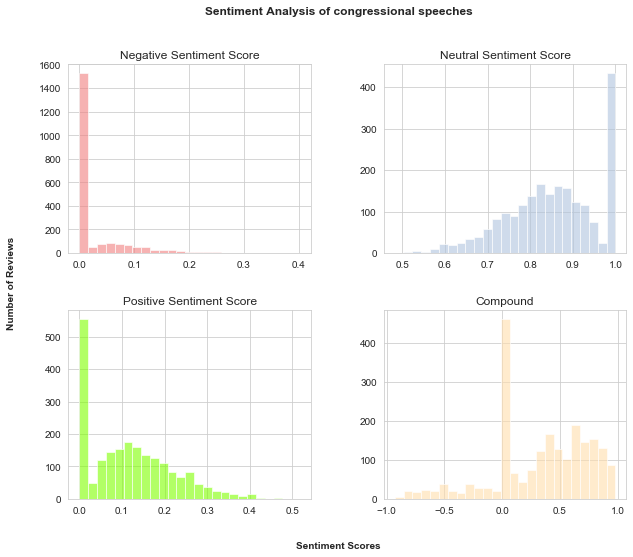

In [172]:
# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
congress_114_bills_df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
congress_114_bills_df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
congress_114_bills_df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
congress_114_bills_df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of congressional speeches\n\n', fontsize=12, fontweight='bold');

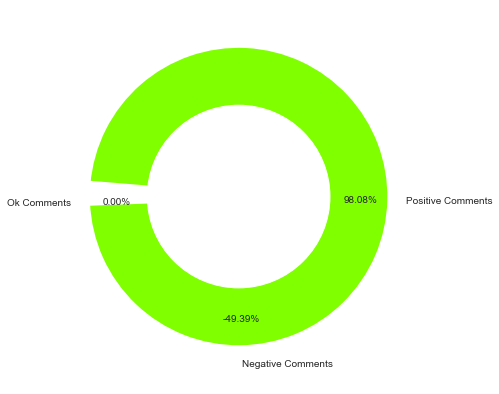

In [173]:
percentiles = congress_114_bills_df.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])

# assign the data
neg = percentiles['5%']
mid = percentiles['20%']
pos = percentiles['max']
names = ['Negative Comments', 'Ok Comments','Positive Comments']
size = [neg, mid, pos]

# call a pie chart
plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

/Users/yc00027/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/yc00027/py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


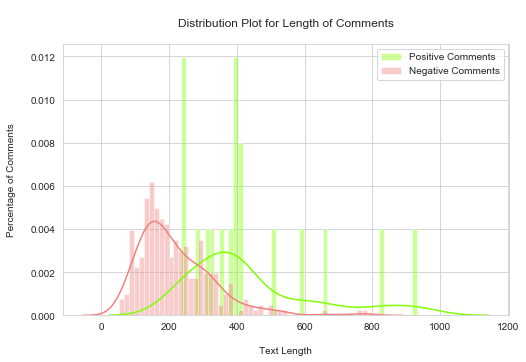

In [174]:
# full dataframe with POSITIVE comments
df_pos = congress_114_bills_df.loc[congress_114_bills_df.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['sentence'].tolist()

# full dataframe with NEGATIVE comments
df_neg = congress_114_bills_df.loc[congress_114_bills_df.sentiment_compound < 0.0]

# only corpus of NEGATIVE comments
neg_comments = df_neg['sentence'].tolist()

df_pos['text_length'] = df_pos['sentence'].apply(len)
df_neg['text_length'] = df_neg['sentence'].apply(len)

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');